<a href="https://colab.research.google.com/github/mateus-miguel/case-dadosfera/blob/main/EDA%20Visuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install boto3

In [4]:
import os
import json
import boto3

# Chaves de acesso AWS


# Geramos um cliente S3 após definir as chaves de acesso do user IAM
s3 = boto3.client('s3')

bucket = 'dadosfera-datalake'
file_path = 'gold/products_enriched_batch00_1000rows.json'

# Obter JSON enriquecido dos produtos
obj = s3.get_object(
    Bucket=bucket,
    Key=file_path
)

dados = json.loads(obj["Body"].read())

['USA', 'Korea', 'USA', 'USA', 'USA', 'USA', 'Switzerland', 'USA', 'USA', 'USA', 'USA', 'India', 'USA', 'USA', 'USA', 'USA', 'USA', 'USA', 'USA', 'Germany', 'USA', 'USA', 'USA', 'Turkey', 'India', 'USA', 'USA', 'USA', 'USA', 'USA', 'USA', 'Indonesia', 'USA', 'Poland', 'Spain', 'USA', 'USA', 'Italy', 'USA', 'USA', 'USA', 'USA', 'USA', 'USA', 'USA', 'India', 'Germany', 'USA', 'USA', 'USA', 'USA', 'USA', 'USA', 'USA', 'USA', 'USA', 'USA', 'USA', 'USA', 'USA', 'USA', 'USA', 'China', 'USA', 'USA', 'Canada', 'USA', 'USA', 'USA', 'USA', 'USA', 'USA', 'USA', 'Vanuatu', 'USA', 'USA', 'USA', 'USA', 'France', 'USA', 'USA', 'Japan', 'USA', 'USA', 'USA', 'South Korea', 'USA', 'USA', 'USA', 'USA', 'USA', 'USA', 'USA', 'USA', 'Japan', 'USA', 'USA', 'USA', 'South Korea', 'Europe', 'USA', 'USA', 'China', 'Germany', 'USA', 'USA', 'USA', 'USA', 'USA', 'USA', 'Mexico', 'China', 'UK', 'USA', 'China', 'USA', 'USA', 'USA', 'USA', 'Turkey', 'USA']


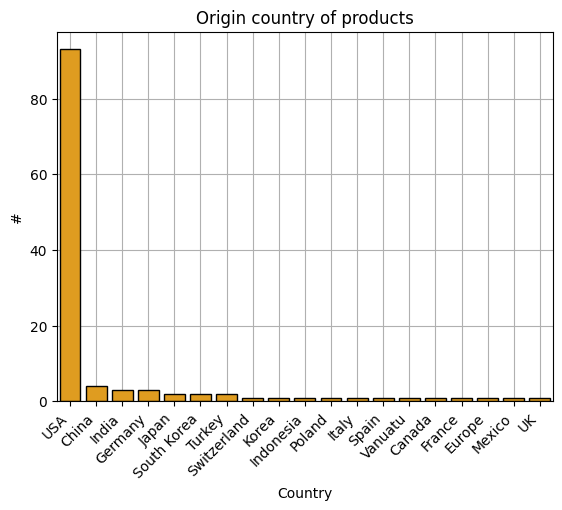

In [90]:
# --- CONTAGEM PAÍSES DE ORIGEM ---
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Explorando a chave 'origin_country'
countries = []

for dado in dados:
  countries.append(dado['origin_country'])

# Filtrando '', 'null' e None
countries = list(filter(lambda x : x != None and x != '' and x != 'null' and x != 'Imported', countries))

countries = [x.replace('United States', 'USA') for x in countries]

print(countries)

# Pandas Series
counts = pd.Series(countries).value_counts().reset_index()
counts.columns = ['country', 'count']

# Criando gráfico de barras
sns.barplot(data=counts, x='country', y='count', color='orange', edgecolor='k', zorder=2)
plt.xticks(rotation=45, ha='right')
plt.title('Origin country of products')
plt.xlabel('Country')
plt.ylabel('#')
plt.grid(zorder=0)
plt.show()

Tamanho da lista de categorias: 1394
Quantidade de categorias geradas: 160
0.8170731707317073
            category  count
0      home & living    358
1           clothing    196
2        electronics    144
3             health     52
4               toys     49
5        accessories     45
6             beauty     44
7             sports     35
8         automotive     33
9            outdoor     30
10             tools     24
11  food & beverages     20
12           jewelry     20
13              pets     20
14   office supplies     18
15           kitchen     15
16       supplements      9
17             decor      9
18          lighting      9
19             games      9
20              misc    255


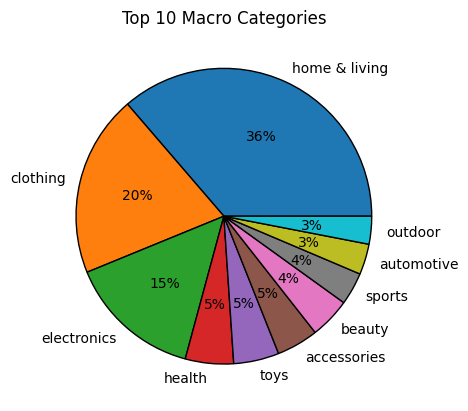

In [85]:
# --- CONTAGEM DAS CATEGORIAS ---

# Explorando a chave 'origin_country'
categories = []

for dado in dados:
  categories.append(dado['category'])

# Processo de flatten como cada item de categoria é uma lista de 1-2 categorias
categories = [item for sublist in categories for item in sublist]

print(f'Tamanho da lista de categorias: {len(categories)}')

# Processo de normalização (muitas categorias semelhantes)
normalization = {
    'home & living': {'home goods', 'home', 'homeware', 'home products'},
    'clothing': {'clothing', 'footwear', 'winter boots', 'beach sandals'},
    'electronics': {'electronics', 'electronic accessories'},
    'beauty': {'beauty', 'cosmetics', 'skincare', 'hair care'},
    'health': {'health', 'healthcare', 'health & personal care', 'personal care'},
    'sports': {'sports', 'sports equipment', 'fitness', 'exercise equipment'},
    'outdoor': {'outdoor', 'outdoors', 'outdoor gear', 'outdoor equipment', 'outdoor recreation'},
    'pets': {'pet care', 'pet supplies', 'pet food'},
    'food & beverages': {'food', 'food and beverage', 'food & beverage'}
}

# Invertendo a normalização para acessar itens da lista de categorias e converter a formas padrão/canônicas
inverse_normalization = {
    variant: canonical
    for canonical, variants in normalization.items()
    for variant in variants
}

# Aplicando a normalização para macro-categorias
normalized_categories = [
    inverse_normalization.get(category, category)
    for category in categories
]

# Pandas Series
counts = pd.Series(normalized_categories).value_counts().reset_index()
counts.columns = ['category', 'count']

print(f'Quantidade de categorias geradas: {counts['category'].size}')
print(counts['count'][0:20].sum() / len(categories))

# Top 5 categorias = 55.38% do total
# Top 10 categorias = 64.56% do total
# Top 20 categorias = 76.33% do total (> 80% já é um ótimo agrupamento, o resto é uma cauda longa)

# Após normalização: Top 20 = 81.71% do total (excelente)

# Reunindo categorias menores ou micro-categorias como 'misc' e mantendo top 20 categorias
top_n = 20

top = counts.iloc[:top_n].copy()
rest = counts.iloc[top_n:]

misc_row = pd.DataFrame({
    'category': ['misc'],
    'count': [rest['count'].sum()]
})

grouped_count = pd.concat([top, misc_row], ignore_index=True)

print(grouped_count.head(21))

plt.pie(grouped_count['count'][0:10], labels=grouped_count['category'][0:10], wedgeprops={'edgecolor': 'k', 'antialiased': True}, autopct='%.0f%%')
plt.title('Top 10 Macro Categories')
plt.show()

In [88]:
# --- CLASSIFICAÇÃO DE MATERIAIS ---

# Chave 'material'
materials = []

for dado in dados:
  materials.append(dado['material'])

materials_clean = list(filter(lambda x: x != '' and x != 'null' and x!= None, materials))
print(materials_clean)

# São vários tipos de materiais, metais, plásticos, tecidos, alguns simples, compostos ou mistos. São várias formas de organizar.

['PU Leather', 'cotton', '304 Stainless Steel', '95% Rayon, 5% Spandex', 'mesh', 'poly-cotton', '100% Nylon', 'aluminum', 'rosewood', 'POLYESTER95% SPANDEX5%', 'Aluminium', '304 stainless steel, borosilicate glass', 'mesh', '100% lightweight polyester fabric', 'stainless steel', 'stainless steel', 'poly-cotton blend', 'Tritan Co-polyester, PP 05, Food-grade Silicone', 'stainless steel', 'plastic', 'die-cast aluminum', 'cardstock', 'lace', 'cotton', '100% cotton burlap', 'plastic', 'Cotton', 'glass', '1095HC steel, American Hickory, leather', 'paper', '100% Fabric', 'cast iron', 'hemp', 'natural ingredients', 'velvet', 'paper', 'designer resin', 'cotton', 'PVC', 'cranberry extract', 'durable materials', 'Oxford Cloth, PVC', '100% Cotton', 'Polyester/ Acrylic', 'paper', 'Three Layer Solid Straw', 'copper', 'European steel', 'linen', 'neoprene', 'faux leather', 'food grade silicone', 'leather', 'silicone', 'wood', 'bamboo', 'BPA free, food grade materials', 'copper', 'velvet', 'Metal + El